In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
import os
from rdkit.Chem import Descriptors
import time
import pickle
import random
from scipy import stats
import math
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import statistics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
import torch.nn.functional as F
from sklearn.metrics import classification_report
from rdkit.Chem import rdMolDescriptors

# Loading Data

The following dataset was obtained from NCI (link: https://cactus.nci.nih.gov/download/nci/index.html). It contains a list of rdkit mol objects corresponding to along with predictions made via GUSAR software for their molecular stability. GUSAR used 35 different quantitative activity structure activity relationship (QSAR) models to generate a consensus of molecular stability. My models are therefore surrogates for GUSAR, with considerably lower complexity. 

link for GUSAR: https://www.way2drug.com/Gusar/

In [2]:
filename = 'NCI-Open_2012-05-01.sdf'

In [3]:
# reading mol objects from sdf file
data = Chem.SDMolSupplier(filename)

In [4]:
len(data)

265242

In [5]:
# checking out first mol object
first_mol = data[0]

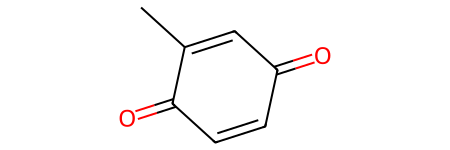

In [6]:
first_mol

In [7]:
# converting data to list
data = list(data)

[00:12:04] Explicit valence for atom # 12 N, 4, is greater than permitted
[00:12:04] ERROR: Could not sanitize molecule ending on line 44170
[00:12:04] ERROR: Explicit valence for atom # 12 N, 4, is greater than permitted
[00:12:04] Explicit valence for atom # 5 N, 4, is greater than permitted
[00:12:04] ERROR: Could not sanitize molecule ending on line 49578
[00:12:04] ERROR: Explicit valence for atom # 5 N, 4, is greater than permitted
[00:12:04] Explicit valence for atom # 1 N, 6, is greater than permitted
[00:12:04] ERROR: Could not sanitize molecule ending on line 250078
[00:12:04] ERROR: Explicit valence for atom # 1 N, 6, is greater than permitted
[00:12:04] Explicit valence for atom # 5 Al, 9, is greater than permitted
[00:12:04] ERROR: Could not sanitize molecule ending on line 348661
[00:12:04] ERROR: Explicit valence for atom # 5 Al, 9, is greater than permitted
[00:12:04] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[00:12:04] ERROR: Could not sanitize mol

In [8]:
# for speed considerations, I decided to limit my model to a random sample of 25,000 molecules
data = random.sample(data, 25000)

<Axes: >

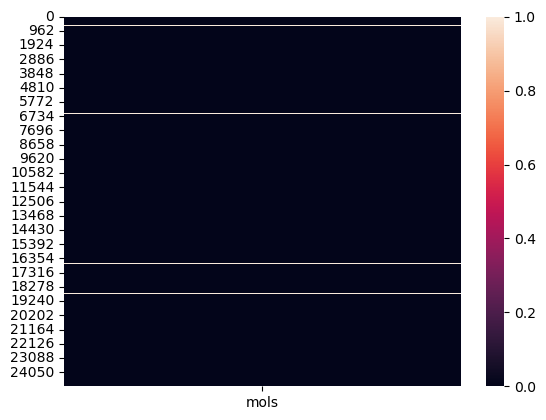

In [9]:
# looking for patterns in null mols 
sns.heatmap(pd.DataFrame({'mols': data}).isna())

In [10]:
# removing null mol objects
data = [mol for mol in data if mol is not None]

<Axes: >

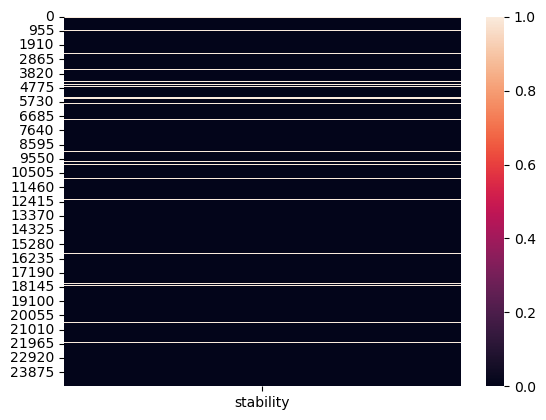

In [11]:
# doing the same for null stability values
stability = [mol.GetProp('GUSAR Human Liver Microsomal Stability Prediction') for mol in data]
sns.heatmap(pd.DataFrame({'stability': [None if val == 'N/A' else 1  for val in stability]}).isna())

In [12]:
data_df = pd.DataFrame({'mols': data, 'stability': stability})
data_df.head()

,mols,stability
0,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,stable
1,<rdkit.Chem.rdchem.Mol object at 0x2bf3c7b50>,stable
2,<rdkit.Chem.rdchem.Mol object at 0x29af8d4d0>,stable
3,<rdkit.Chem.rdchem.Mol object at 0x2a85aa030>,stable
4,<rdkit.Chem.rdchem.Mol object at 0x2a85ef610>,unstable


In [13]:
data_df.describe()

,mols,stability
count,24811,24811
unique,24811,3
top,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,stable
freq,1,18602


In [14]:
# removing all rows where stability is N/A
data_df = data_df[data_df['stability'] != 'N/A']

In [15]:
data_df.describe()

,mols,stability
count,23530,23530
unique,23530,2
top,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,stable
freq,1,18602


In [16]:
# 1 if stable, 0 otherwise
stability_binary = [1 if value == 'stable' else 0 for value in data_df['stability']]
data_df['stability'] = stability_binary
data_df.head()

,mols,stability
0,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,1
1,<rdkit.Chem.rdchem.Mol object at 0x2bf3c7b50>,1
2,<rdkit.Chem.rdchem.Mol object at 0x29af8d4d0>,1
3,<rdkit.Chem.rdchem.Mol object at 0x2a85aa030>,1
4,<rdkit.Chem.rdchem.Mol object at 0x2a85ef610>,0


In [17]:
stability_vc = data_df['stability'].value_counts()

In [18]:
stability_vc

stability
1    18602
0     4928
Name: count, dtype: int64

~79.16% are stable while ~20.84% are unstable

In [19]:
# adding smiles strings to df
data_df['smiles'] = [Chem.MolToSmiles(mol) for mol in data_df['mols']]

In [20]:
data_df.head()

,mols,stability,smiles
0,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,1,CCO[C@H]([C@@H](Nc1ccc([N+](=O)[O-])cc1[N+](=O...
1,<rdkit.Chem.rdchem.Mol object at 0x2bf3c7b50>,1,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
2,<rdkit.Chem.rdchem.Mol object at 0x29af8d4d0>,1,O=c1[nH]c(=S)c2[nH]c(=O)[nH]c2[nH]1
3,<rdkit.Chem.rdchem.Mol object at 0x2a85aa030>,1,COc1ccc(NC(N)=S)cc1OC
4,<rdkit.Chem.rdchem.Mol object at 0x2a85ef610>,0,NC(=S)N/N=C/c1cc2c(cc1[N+](=O)[O-])OCO2


In [21]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23530 entries, 0 to 24810
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mols       23530 non-null  object
 1   stability  23530 non-null  int64 
 2   smiles     23530 non-null  object
dtypes: int64(1), object(2)
memory usage: 735.3+ KB


# Generating Fingerprints

In [22]:
# get morgan fingerprint with 1024 bits and radius of 2
def get_morgan_fp(mol):
    return rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

In [23]:
morgan_fps = [get_morgan_fp(mol) for mol in data_df['mols']]

In [24]:
any([fp is None for fp in morgan_fps])
# checking for null fingerprints

False

In [25]:
# converting fingerprints to pytorch tensors
morgan_fps = torch.tensor(morgan_fps).float()

In [26]:
# adding to df
data_df['morgan_fps'] = list(morgan_fps)

In [27]:
data_df.head()

,mols,stability,smiles,morgan_fps
0,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,1,CCO[C@H]([C@@H](Nc1ccc([N+](=O)[O-])cc1[N+](=O...,"[tensor(0.), tensor(1.), tensor(0.), tensor(0...."
1,<rdkit.Chem.rdchem.Mol object at 0x2bf3c7b50>,1,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,<rdkit.Chem.rdchem.Mol object at 0x29af8d4d0>,1,O=c1[nH]c(=S)c2[nH]c(=O)[nH]c2[nH]1,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,<rdkit.Chem.rdchem.Mol object at 0x2a85aa030>,1,COc1ccc(NC(N)=S)cc1OC,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,<rdkit.Chem.rdchem.Mol object at 0x2a85ef610>,0,NC(=S)N/N=C/c1cc2c(cc1[N+](=O)[O-])OCO2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [28]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23530 entries, 0 to 24810
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mols        23530 non-null  object
 1   stability   23530 non-null  int64 
 2   smiles      23530 non-null  object
 3   morgan_fps  23530 non-null  object
dtypes: int64(1), object(3)
memory usage: 919.1+ KB


# Generating Molecular Descriptors

In [29]:
# adding molecular descriptors to dataframe
data_df['descriptors'] = data_df['mols'].apply(Descriptors.CalcMolDescriptors)

[00:13:36] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforge3/conda-bld/rdkit_1709960390757/work/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
****

[00:13:36] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforge3/conda-bld/rdkit_1709960390757/work/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
****

[00:13:36] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforge3/conda-bld/rdkit_1709960390757/work/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
****

[00:13:36] 

****
Pre-condition Violation
bad result vector size
Violatio

In [30]:
# extracting molecular descriptors into separate columns
for desc_name in data_df['descriptors'].iloc[0].keys():
    data_df[desc_name] = data_df['descriptors'].apply(lambda x: x[desc_name])
data_df.drop(columns = 'descriptors', inplace=True)

/var/folders/gm/47zps1xj7rz10npj29fl9l6r0000gn/T/ipykernel_72007/1962512577.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[desc_name] = data_df['descriptors'].apply(lambda x: x[desc_name])
/var/folders/gm/47zps1xj7rz10npj29fl9l6r0000gn/T/ipykernel_72007/1962512577.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[desc_name] = data_df['descriptors'].apply(lambda x: x[desc_name])
/var/folders/gm/47zps1xj7rz10npj29fl9l6r0000gn/T/ipykernel_72007/1962512577.py:3: PerformanceWarning: DataFrame is highly fragment

In [31]:
data_df.head()

,mols,stability,smiles,morgan_fps,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,1,CCO[C@H]([C@@H](Nc1ccc([N+](=O)[O-])cc1[N+](=O...,"[tensor(0.), tensor(1.), tensor(0.), tensor(0....",12.667080,12.667080,0.018386,-1.783066,0.094200,14.104167,...,0,0,0,0,0,0,0,0,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x2bf3c7b50>,1,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",11.830105,11.830105,0.004897,-0.583964,0.787776,48.956522,...,0,0,0,0,0,0,0,0,0,0
2,<rdkit.Chem.rdchem.Mol object at 0x29af8d4d0>,1,O=c1[nH]c(=S)c2[nH]c(=O)[nH]c2[nH]1,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",10.799815,10.799815,0.214907,-0.441898,0.419272,10.666667,...,0,0,0,0,0,0,0,0,0,0
3,<rdkit.Chem.rdchem.Mol object at 0x2a85aa030>,1,COc1ccc(NC(N)=S)cc1OC,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",5.334818,5.334818,0.219648,0.219648,0.740828,9.285714,...,0,0,0,0,0,0,0,0,0,0
4,<rdkit.Chem.rdchem.Mol object at 0x2a85ef610>,0,NC(=S)N/N=C/c1cc2c(cc1[N+](=O)[O-])OCO2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",10.895274,10.895274,0.032735,-0.537619,0.354821,12.666667,...,0,0,0,0,0,0,0,0,0,0


## Dealing with null descriptors

<Axes: >

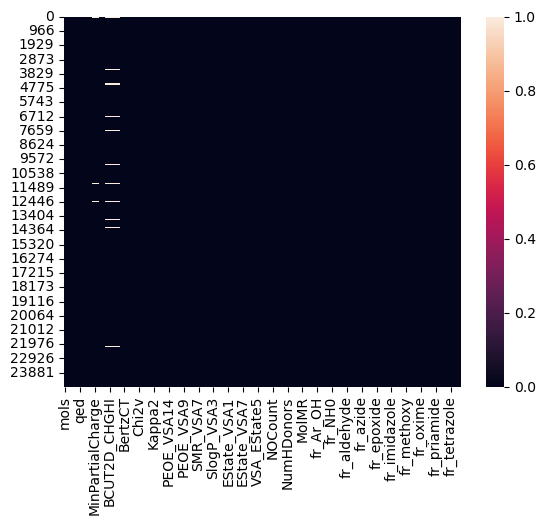

In [32]:
# heatmap showing null values
sns.heatmap(data_df.isna())

In [33]:
# finding all descriptors with null values
descs_with_na = []
for col in data_df.keys()[4:]:
    if any(data_df[col].apply(math.isnan)):
        descs_with_na.append(col)

In [34]:
descs_with_na

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [35]:
# imputing mean of columns for null values
desc_keys = data_df.keys()[4:]
data_df[desc_keys] = data_df[desc_keys].fillna(data_df[desc_keys].mean())
data_df.head()

,mols,stability,smiles,morgan_fps,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,<rdkit.Chem.rdchem.Mol object at 0x2a59b3610>,1,CCO[C@H]([C@@H](Nc1ccc([N+](=O)[O-])cc1[N+](=O...,"[tensor(0.), tensor(1.), tensor(0.), tensor(0....",12.667080,12.667080,0.018386,-1.783066,0.094200,14.104167,...,0,0,0,0,0,0,0,0,0,0
1,<rdkit.Chem.rdchem.Mol object at 0x2bf3c7b50>,1,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",11.830105,11.830105,0.004897,-0.583964,0.787776,48.956522,...,0,0,0,0,0,0,0,0,0,0
2,<rdkit.Chem.rdchem.Mol object at 0x29af8d4d0>,1,O=c1[nH]c(=S)c2[nH]c(=O)[nH]c2[nH]1,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",10.799815,10.799815,0.214907,-0.441898,0.419272,10.666667,...,0,0,0,0,0,0,0,0,0,0
3,<rdkit.Chem.rdchem.Mol object at 0x2a85aa030>,1,COc1ccc(NC(N)=S)cc1OC,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",5.334818,5.334818,0.219648,0.219648,0.740828,9.285714,...,0,0,0,0,0,0,0,0,0,0
4,<rdkit.Chem.rdchem.Mol object at 0x2a85ef610>,0,NC(=S)N/N=C/c1cc2c(cc1[N+](=O)[O-])OCO2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....",10.895274,10.895274,0.032735,-0.537619,0.354821,12.666667,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

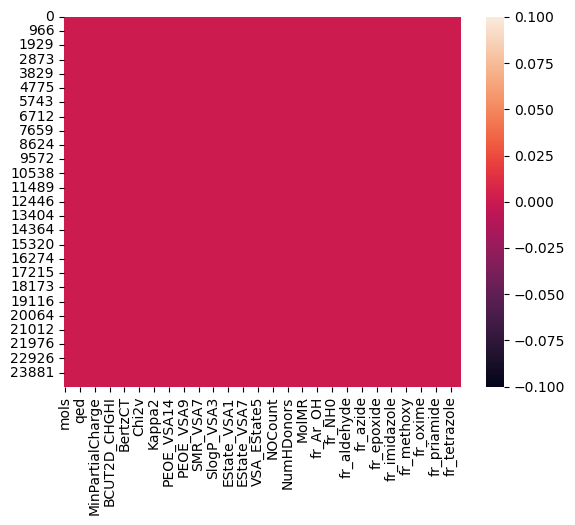

In [36]:
# new heatmap showing null values were successfully removed
sns.heatmap(data_df.isna())

## Dealing with infinite values

When trying to perform feature selection, I encountered an error where some of the descriptors were equal to infinity. I invesigated this below

In [37]:
inf_df = pd.DataFrame()
for col in data_df.keys()[4:]:
    for i, val in enumerate(data_df[col]):
        if math.isinf(val):
            print(f"Smiles: {data_df['smiles'].iloc[i]},  Infinite Value: {col}, Idx: {i}")

Smiles: CCCCCCCCCCCC[Sn](C)(C)OC(C)=O,  Infinite Value: MaxPartialCharge, Idx: 36
Smiles: CCCC[As@@](=O)(O)CCCc1ccccc1,  Infinite Value: MaxPartialCharge, Idx: 186
Smiles: O=C(O)c1ccccc1[As](=O)(O)O,  Infinite Value: MaxPartialCharge, Idx: 309
Smiles: CCOC(=O)C1(C(=O)OCC)C[C@@H](C[Hg]OC(C)=O)O[C@H](C[Hg]OC(C)=O)C1,  Infinite Value: MaxPartialCharge, Idx: 385
Smiles: CC(C)=C[Sb@TB3](Br)(C=C(C)C)(C=C(C)C)C=C(C)C,  Infinite Value: MaxPartialCharge, Idx: 412
Smiles: CCCC[Sn](CCCC)(CCCC)OC(C)=O,  Infinite Value: MaxPartialCharge, Idx: 481
Smiles: CN(C)[P@TB4](N)(Cl)(N(C)C)N(C)C,  Infinite Value: MaxPartialCharge, Idx: 598
Smiles: CC(=O)Nc1cc([As](=O)(O)O)ccc1O,  Infinite Value: MaxPartialCharge, Idx: 755
Smiles: CCC[As](CCC)SC[C@@H]1O[C@H](OC(C)=O)[C@H](OC(C)=O)[C@H](OC(C)=O)[C@H]1OC(C)=O,  Infinite Value: MaxPartialCharge, Idx: 777
Smiles: c1ccc(C2CCN(C3[S-]->[Cu+2]4(<-[S-]C(=[SH]4)N4CCC(c5ccccc5)CC4)[SH]=3)CC2)cc1,  Infinite Value: MaxPartialCharge, Idx: 875
Smiles: CC[As](CC)SC[C@@H](O)C

It appears that the infinite values all correspond the maximum/minimum partial charge and maximum/minimum absolute partial charge attributes. Additonally, the structures of these molecules all appear to contain long strings of carbons. 

In [38]:
features_with_inf = ['MaxPartialCharge', 'MaxAbsPartialCharge', 'MinPartialCharge', 'MinAbsPartialCharge']

In [39]:
# new dataframe containing rows with infinite values
desc_df = data_df.drop(['morgan_fps', 'mols', 'smiles'], axis=1)
inf_mask = desc_df.apply(np.isinf).any(axis=1)
desc_df[inf_mask]

,stability,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
36,0,10.971744,10.971744,0.076038,-2.433612,0.323382,11.578947,377.157,342.885,378.158075,...,0,0,0,0,0,0,0,0,8,0
195,0,11.779305,11.779305,0.520976,-3.463183,0.780098,14.625000,284.231,263.063,284.075751,...,0,0,0,0,0,0,0,0,0,0
327,1,10.850023,10.850023,0.337963,-5.105272,0.578329,11.230769,246.050,238.994,245.950945,...,0,0,0,0,0,0,0,0,0,0
409,0,12.778457,12.778457,0.145720,-1.992260,0.185753,20.142857,775.566,749.358,778.098968,...,0,0,0,0,0,0,0,0,0,0
439,0,4.191667,4.191667,1.376088,-3.278241,0.466801,12.833333,422.064,393.840,420.041254,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24501,1,11.159125,11.159125,0.000000,-1.968251,0.508948,9.600000,332.446,323.374,330.891483,...,0,0,0,0,0,0,0,0,0,0
24532,1,11.122593,11.122593,0.483704,-2.105926,0.652931,10.750000,220.888,206.776,222.006660,...,0,0,0,0,0,0,0,0,0,0
24667,1,11.996713,11.996713,0.199893,-3.129672,0.650120,33.045455,419.022,398.862,420.034331,...,0,0,0,0,0,0,0,0,0,0
24700,0,13.367667,13.367667,0.087647,-3.113133,0.354579,11.000000,424.375,403.207,424.080837,...,0,0,0,0,0,0,0,0,0,0


In [40]:
desc_df[inf_mask]['stability'].value_counts(normalize=True)

stability
1    0.709945
0    0.290055
Name: proportion, dtype: float64

The molecules with infinite values seem to be overrepresented as unstable. This makes sense considering their abnormal structure. 

/Users/christian_g/anaconda3/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


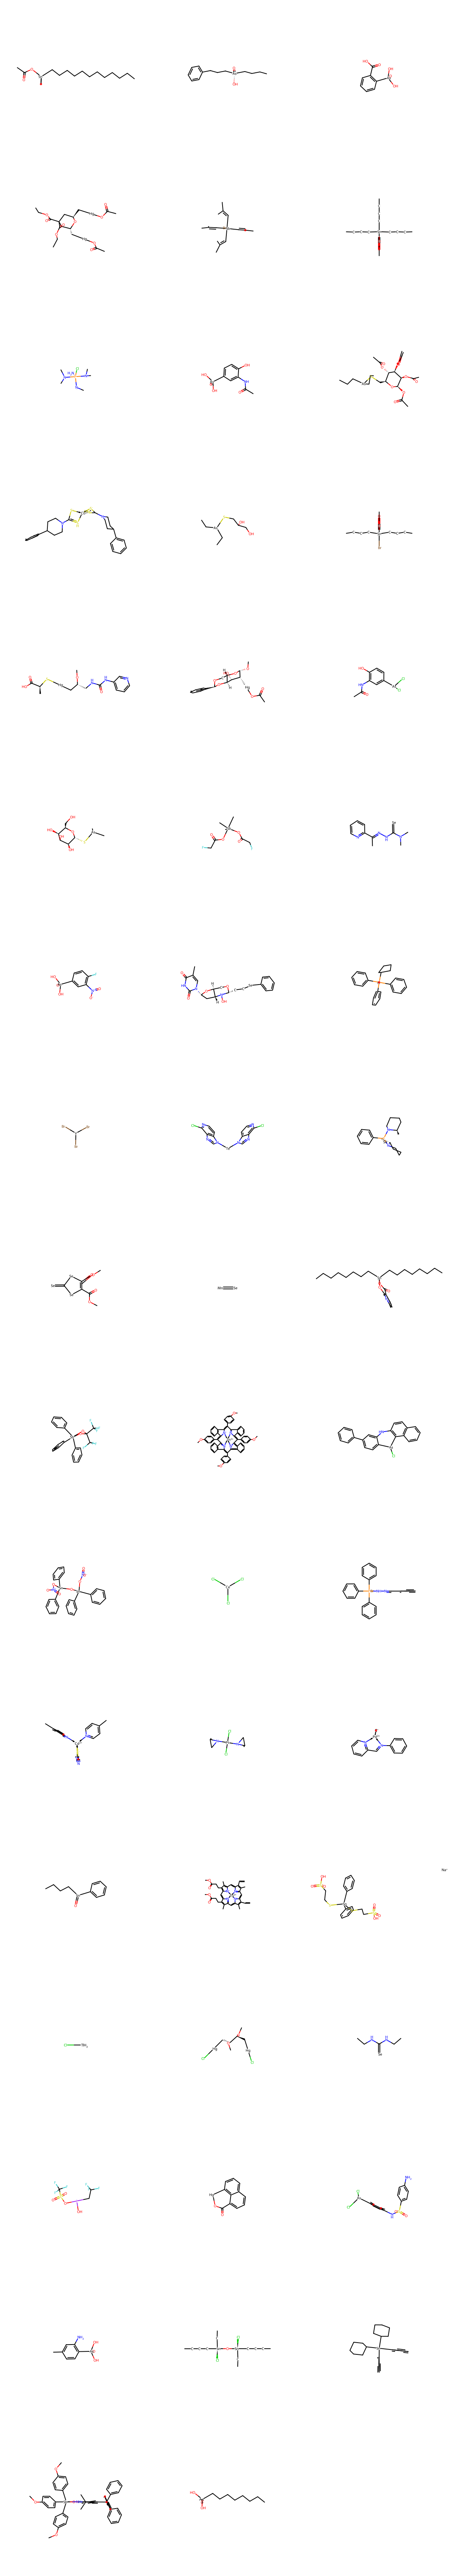

In [41]:
# confirming molecules have similar structure with long carbon chains
mols_inf = data_df['mols'][inf_mask]
Chem.Draw.MolsToGridImage(mols_inf, subImgSize=(400, 400))

The documentation on partial charge attributes for rdkit is lacking, so it is not clear why these values are infinite. My guess would be that the presence of long carbon charges causes the potential partial charge to be very high, as it can be distributed across many molecules. This may result in some error in calculations done by the Gasteiger method, resulting in infinite values.

In [42]:
data_df[features_with_inf].describe()

/Users/christian_g/anaconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/christian_g/anaconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/christian_g/anaconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/christian_g/anaconda3/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,MaxPartialCharge,MaxAbsPartialCharge,MinPartialCharge,MinAbsPartialCharge
count,2.353000e+04,2.353000e+04,2.353000e+04,2.353000e+04
mean,inf,inf,inf,inf
std,NaN,NaN,NaN,NaN
min,-1.000000e+00,4.470379e-02,-1.000000e+00,1.838365e-04
25%,1.853767e-01,3.498308e-01,-4.809434e-01,1.852699e-01
50%,2.690761e-01,4.342687e-01,-3.989167e-01,2.659414e-01
75%,3.307989e-01,4.889068e-01,-3.376638e-01,3.269634e-01
max,inf,inf,inf,inf


I am assuming that having a value of infinity for either the MinPartialCharge or MinAbsPartialCharge is meant to correspond to negative charge. We'll substitute either the max or min values for the 4 columns into their respective infinite values, so that these molecules do not have to be removed. 

In [43]:
# obtaining the maximum non-infinite values for MaxPartialCharge and MaxAbsPartialCharge
max_MaxPartialCharge = max([val for val in data_df['MaxPartialCharge'] if not math.isinf(val)])
max_MaxAbsPartialCharge = max([val for val in data_df['MaxAbsPartialCharge'] if not math.isinf(val)])
# doing the same for min counterparts, except obtaining their minimum
min_MinPartialCharge = min([val for val in data_df['MinPartialCharge'] if not math.isinf(val)])
min_MinAbsPartialCharge = min([val for val in data_df['MinAbsPartialCharge'] if not math.isinf(val)])

In order to still include these molecules in our model, we'll substitute the maximum non-infinite value of the MaxPartialCharge and MaxAbsPartialCharge values.

In [44]:
data_df['MaxPartialCharge'] = [val if not math.isinf(val) else max_MaxPartialCharge for val in data_df['MaxPartialCharge']]
data_df['MaxAbsPartialCharge'] = [val if not math.isinf(val) else max_MaxAbsPartialCharge for val in data_df['MaxAbsPartialCharge']]
data_df['MinPartialCharge'] = [val if not math.isinf(val) else min_MinPartialCharge for val in data_df['MinPartialCharge']]
data_df['MinAbsPartialCharge'] = [val if not math.isinf(val) else min_MinAbsPartialCharge for val in data_df['MinAbsPartialCharge']]

In [45]:
data_df[features_with_inf].describe()

,MaxPartialCharge,MaxAbsPartialCharge,MinPartialCharge,MinAbsPartialCharge
count,23530.000000,23530.000000,23530.000000,23530.000000
mean,0.290349,0.453467,-0.424233,0.247036
std,0.258352,0.245192,0.147346,0.104243
min,-1.000000,0.044704,-1.000000,0.000184
25%,0.185377,0.349831,-0.481230,0.178490
50%,0.269076,0.434269,-0.414495,0.262682
75%,0.330799,0.488907,-0.342190,0.324812
max,2.000000,2.000000,2.000000,2.000000


## Scaling Large Molecular Descriptor Values

Again, when trying to perform variable selection I encountered another issue. When trying to identify an appropriate variance threshold by analyzing the standard deviations of all molecular descriptors, I noticed that some have unusually large values. In order to prevent these features from negatively impacting model optimization, it is necessary to scale them down. 

In [46]:
desc_df = data_df.drop(['morgan_fps', 'mols', 'smiles', 'stability'], axis=1)
desc_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.667080,12.667080,0.018386,-1.783066,0.094200,14.104167,676.596,644.340,676.208883,258,...,0,0,0,0,0,0,0,0,0,0
1,11.830105,11.830105,0.004897,-0.583964,0.787776,48.956522,316.441,288.217,316.203845,126,...,0,0,0,0,0,0,0,0,0,0
2,10.799815,10.799815,0.214907,-0.441898,0.419272,10.666667,184.180,180.148,184.005496,62,...,0,0,0,0,0,0,0,0,0,0
3,5.334818,5.334818,0.219648,0.219648,0.740828,9.285714,212.274,200.178,212.061949,76,...,0,0,0,0,0,0,0,0,0,0
4,10.895274,10.895274,0.032735,-0.537619,0.354821,12.666667,268.254,260.190,268.026626,94,...,0,0,0,0,0,0,0,0,0,0


first, we'll need to select an appropriate variance threshold for removal. We can do this by analyzing the standard devations of all of the molecular descriptors.

Text(0.5, 0, 'molecular descriptor standard deviations')

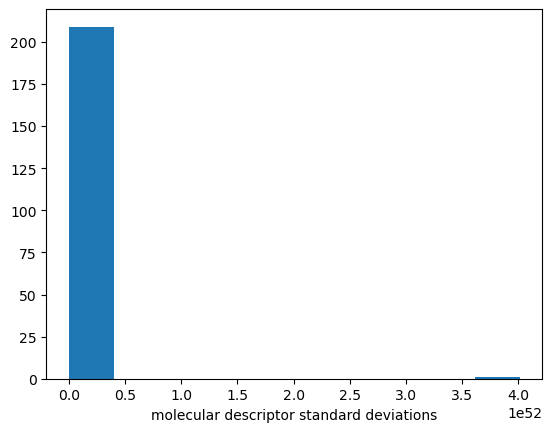

In [47]:
# here we can visualize the outlier
stds=desc_df.std()
plt.hist(stds)
plt.xlabel('molecular descriptor standard deviations')

In [48]:
# identifying the feature with large values and stdev
outlier_desc = stds.idxmax()
outlier_desc, stds.max()

('Ipc', 4.0124303049009476e+52)

In [49]:
data_df['Ipc'].describe()

count    2.353000e+04
mean     2.627918e+50
std      4.012430e+52
min      2.000000e+00
25%      3.181150e+03
50%      3.901162e+04
75%      7.080363e+05
max      6.154798e+54
Name: Ipc, dtype: float64

Here we can see the feature is Ipc, which corresponds to the isoelectric point cluster. Rdkit's standard implementation of Ipc is known to produce very large values for large, branched molecules, so the Descriptors.Ipc method has an avg=True option that calculates Ipc as an average and thus results in manageable numbers. I've implemented this below and replaced the previous Ipc values.

In [ ]:
# Descriptors.Ipc(data_df['Ipc'], avg=True)
Ipc_corrected = data_df['mols'].apply(lambda mol: Descriptors.Ipc(mol, avg=True))

In [ ]:
# here, we see that the Ipc values have been scaled down to more reasonable values
pd.DataFrame(Ipc_corrected).describe()

In [ ]:
# applying changes to main dataframe
data_df['Ipc']=Ipc_corrected
data_df['Ipc'].describe()

# Exploratory Data Analysis (Univariate and Bivariate)

In [ ]:
# list of all molecular descriptors
all_descs = data_df.keys()[4:]

We'll start by performing t-tests for all molecular descriptors to test for a statistically significant difference between stable and unstable molecules. The t-test we'll be performing for all of the descriptors is as follows: 

\begin{align*}
H_0: \mu_{stable} &= \mu_{unstable} \\
H_A: \mu_{stable} &\neq \mu_{unstable}
\end{align*}

In [ ]:
ttest_results = {}
for desc in all_descs:
    vals_stable = data_df[data_df['stability']==1][desc]
    vals_unstable = data_df[data_df['stability']==0][desc]
    # scipy t-test for means of two independent samples
    result = stats.ttest_ind(vals_stable, vals_unstable, alternative='two-sided')
    pvalue = result[1]
    if not math.isnan(pvalue):
        ttest_results[desc]=pvalue

In [ ]:
# adjusting p-values with bonferroni correction
num_tests = len(ttest_results)
for desc in ttest_results.keys():
    ttest_results[desc] *= num_tests

In [ ]:
# list of p-values
ttest_results

In [ ]:
# counting number of hypothesis rejections based on significance of 0.05
alpha = 0.05
null_rejections = 0
for key in ttest_results.keys():
    if ttest_results[key] < alpha:
        null_rejections += 1

In [ ]:
null_rejections 

We can see that the number of rejections of the null hypothesis is a large proportion of our 210 descriptors (~75%). While I won't remove those features with non-significant p-values, as doing so is controversial for machine learning models with many features, these tests nonetheless indicate that we can expect our model based on molecular descriptors to make meaningful predictions about molecular stability.

## Analyzing Distributions of Common Molecular Descriptors

Out of curiosity, I wanted to analyze the distribution of a few common molecular descriptors in the sample, and compare distribution for stable and unstable molecules.

In [ ]:
def molecular_distplot(descriptor, xlab):
    sns.histplot(data=data_df[data_df['stability']==0][descriptor], kde=True, label='unstable', color='red', stat='density')
    sns.histplot(data=data_df[data_df['stability']==1][descriptor], kde=True, label='stable', color='blue', stat='density')
    plt.title(f"Distribution of {xlab} for Stable and Unstable Molecules in Liver Microsome")
    plt.legend(labels=['unstable', 'stable'])
    plt.xlabel(xlab)

In [ ]:
molecular_distplot('MolWt', 'Molecular Weight (AMU)')

In [ ]:
data_df.groupby('stability')['MolWt'].mean()

In [ ]:
molecular_distplot('HeavyAtomMolWt', 'Heavy (Non-Hydrogen) Atom Molecular Weight (AMU)')

In [ ]:
molecular_distplot('NumValenceElectrons', 'Number of Valence Electrons')

In [ ]:
molecular_distplot('Ipc', 'Number of Valence Electrons')

We can see from the above graph and table that stable molecules tend to have a lower molecular weight than unstable.

# PyTorch Neural Network - Fingerprints

In [ ]:
# dictionary containing loss for final test set for all models, for comparison later
all_test_losses = {}

First, I wanted to try and build a model using the morgan fingerprints generated earlier.

## Defining Model, Loss Function, and Creating Batches

In [ ]:
# randomly shuffle rows of dataframe
data_df = data_df.sample(frac=1)

In [ ]:
# obtaining input (x) and output (y) from data_df
x = list(data_df['morgan_fps'])
len(x)

In [ ]:
y = [torch.tensor([val]).float() for val in data_df['stability']]
len(y)

In [ ]:
# 75, 15, 10 % splits for train, validation, and test sets, respectively
def split_list(input_list, train_percent=0.75, val_percent=0.15, test_percent=0.10):
    # Calculate the number of items for each set
    train_size = int(len(input_list) * train_percent)
    val_size = int(len(input_list) * val_percent)
    test_size = len(input_list) - train_size - val_size

    # Split the list
    train_set = input_list[:train_size]
    val_set = input_list[train_size:train_size + val_size]
    test_set = input_list[train_size + val_size:]

    return train_set, val_set, test_set

The neural network I'll start with is a simple feedforward with 2 fully connected linear layers and ReLU activation functions. At the end of the neural net I'll apply a sigmoid function as this is a binary classification problem and we want the output to be interpreted as a probability from 0 to 1.

In [ ]:
# feedforward binary classification model with one hidden layer
class nnet_ff_bc(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.nnet_ff_bc = nn.Sequential(
        # first hidden layer
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        # second hidden layer
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        # output layer
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
        
    def forward(self, x):
        return self.nnet_ff_bc(x)

For the loss function, we'll use binary cross entropy as it allows for a smooth loss function with respect to model parameters for binary classification problems.

In [ ]:
bce_loss = nn.BCELoss()

In [ ]:
# return loss for validation set of current model
def validate_model(x_val_in, y_val_in, nnet: nn.Module, loss_function: torch.optim):
    nnet.eval()
    output = nnet(torch.stack(x_val_in))
    target = torch.stack(y_val_in)
    loss = loss_function(output, target)
    return loss

In [ ]:
# perform one optimization step
def train_model_step(x_train_in, y_train_in, nnet, loss_function, optimizer):
    nnet.train()
    optimizer.zero_grad()
    output = nnet(torch.stack(x_train_in))
    output_std = torch.std(output)
    target = torch.stack(y_train_in)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    output_mean = torch.mean(output)
    target_mean = torch.mean(target)
    return loss, output_mean, output_std, target_mean

In [ ]:
def test_model(x_test_in, y_test_in, nnet, loss_function):
    nnet.eval()
    output = nnet(torch.stack(x_test_in))
    target = torch.stack(y_test_in)
    loss = loss_function(output, target)
    return loss

In [ ]:
def make_batches(batch_size, input_list):
    # Calculate the number of batches
    num_batches = len(input_list) // batch_size
    if len(input_list) % batch_size != 0:
        num_batches += 1 # Add one more batch for the remaining elements

    # Generate batches
    batches = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size
        batch = input_list[start_index:end_index]
        batches.append(batch)

    return batches

## Training model

The Adam optimization algorithm has been shown to perform well on many neural network architectures with little hyperparameter tuning required. By computing momentum for gradients, Adam is able to navigate saddle points and local minima which would otherwise results in suboptimal models for algorithms like stochastic gradient descent. Additonally, Adam computes adjusted learning rates for each of the model parameters based on their gradient history, allowing it to achieve convergence more efficiently. 

In [ ]:
# full model training cycle
def train_model(x_in, y_in, nnet_in, batch_size_in, lr_in, loss_function):
    # splitting data into train, validation, and test sets
    x_train, x_val, x_test = split_list(x)
    y_train, y_val, y_test = split_list(y)

    #splitting training data into batches
    x_train_batches = make_batches(batch_size_in, x_train)
    y_train_batches = make_batches(batch_size_in, y_train)

    # obtaining number of training epochs based on number of batches
    num_epochs = len(x_train_batches)
    
    # Load nnet
    nnet = nnet_in
    
    # initializing Adam optimization function
    optim = Adam(nnet.parameters(), lr=lr_in)
    
    # history of training and validation losses
    loss_train_list = []
    loss_val_list = []
    
    for epoch in range(num_epochs):
        # obtaning batch data and targets
        x_train_batch = x_train_batches[epoch]
        y_train_batch = y_train_batches[epoch]
        # validating model
        val_loss = validate_model(x_val, y_val, nnet, loss_function)
        loss_val_list.append(val_loss.item())
        print(f'Validation Loss for Epoch {epoch}: {val_loss}')
        # training step
        train_loss, output_mean, output_std, target_mean = train_model_step(x_train_batch, y_train_batch, nnet, loss_function, optim)
        loss_train_list.append(train_loss.item())
        print(f'Training Loss for Epoch {epoch}: {train_loss}, Output Mean: {output_mean}, Output Std: {output_std}, \nTarget Mean: {target_mean}')

    # loss for test set
    test_loss = test_model(x_test, y_test, nnet, bce_loss).item()

    print(f"Loss for test set: {test_loss}")
    
    return loss_train_list, loss_val_list, test_loss

In [ ]:
# model hyperparameters
batch_size=256
lr=0.001

# defining nnet
nnet = nnet_ff_bc(1024, 600)

# training neural network
loss_train_list, loss_val_list, test_loss = train_model(x, y, nnet, batch_size, lr, bce_loss)

In [ ]:
# adding test loss to list
all_test_losses['Morgan Fingerprints, FF'] = test_loss

In [ ]:
plt.plot(loss_train_list, color='blue')
plt.plot(loss_val_list, color='red')
plt.legend(labels=['training', 'validation'])
plt.title("Classification of Liver Microsome Compounds as Stable or Unstable \nUsing 1024-bit Morgan Fingerprints and Feedforward nnet")
plt.xlabel('Training iteration')
plt.ylabel('binary cross-entropy (BCE) loss')
plt.show()

Loss for the test set is consistently between 0.3 and 0.4, which is generally considered poor for binary cross-entropy. This is to be expected as the neural network architecture was very simple. Nevertheless, we can clearly observe that the model is able to learn from fingerprint data even with this sub-optimal architecture.

## Fingerprints + Dropout Layers

Because the input is highly multidimensional (1024 features), it may be beneficial to implement a dropout mechanism, which randomly ignores neurons based on a given probability.

In [ ]:
# feedforward neural network with dropout layers for binary classification
class nnet_dropout_bc(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob):
        super().__init__()
        self.nnet_ff_bc = nn.Sequential(
        # first hidden layer
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_prob),
        # second hidden layer
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout_prob),
        # output layer
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
        
    def forward(self, x):
        return self.nnet_ff_bc(x)

In [ ]:
# model hyperparameters
batch_size=256
lr=0.001
dropout_prob=0.25 # 25% dropout rate

# defining nnet
nnet = nnet_dropout_bc(1024, 600, dropout_prob)

# training neural network
loss_train_list, loss_val_list, test_loss = train_model(x, y, nnet, batch_size, lr, bce_loss)

In [ ]:
# adding test loss to list
all_test_losses['Morgan Fingerprints, FF with Dropout'] = test_loss

In [ ]:
plt.plot(loss_train_list, color='blue')
plt.plot(loss_val_list, color='red')
plt.legend(labels=['training', 'validation'])
plt.title("Classification of Liver Microsome Compounds as Stable or Unstable \nUsing 1024-bit Morgan Fingerprints and Feedforward nnet with Dropout Layers")
plt.xlabel('Training iteration')
plt.ylabel('binary cross-entropy (BCE) loss')
plt.show()

Next, I wanted to try and built a model using the molecular descriptors generated earlier.

## Fingerprints + Residual Neural Network

In [ ]:
class ResNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_residual_blocks):
    super().__init__()
    slef.linear0 = nn.Linear(input_dim, hidden_dim)
    self.linear1 = nn.Linear(hidden_dim, hidden_dim)
    self.ReLU1 = nn.ReLU()
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.ReLU2 = nn.ReLU()
    self.linear3 = nn.Linear(hidden_dim, hidden_dim)
    self.last_linear = nn.Linear(hidden_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def res_block(self, x):
    x_identity=x
    x=self.linear1(x)
    x=self.ReLU1(x)
    x=self.linear2(x)
    x=self.ReLU2(x)
    x=torch.add(x, x_identity)
    x=self.linear3(x)
    return x
  
  def forward(self, x):
    x=self.linear0(x)
      
    x=self.last_linear(x)
    x=self.sigmoid(x)
    return x

# Logistic Regression - Descriptors

To start, I felt it was necessary to perform a basic multiple logistic regression using descriptors to compare to neural network approaches later.

In [ ]:
# loading input; the output (y) will be the same as for the fingerprint nnet
x_df = data_df.drop(['morgan_fps', 'mols', 'smiles', 'stability'], axis=1)
x_df.head()

In [ ]:
# converting df to list of tensors
x = []
for i, row, in x_df.iterrows():
    row_as_tensor = torch.tensor(row).float()
    x.append(row_as_tensor)

In [ ]:
# converting to numpy arrays for scikit learn
x_lr = np.array([val.numpy() for val in x])
y_lr = np.array([val.numpy() for val in y])

In [ ]:
# train and test splits
x_lr_train, x_lr_test, y_lr_train, y_lr_test = train_test_split(x_lr, y_lr, test_size=0.1)

In [ ]:
# initializing and fitting model
model = LogisticRegression()
model.fit(x_lr_train, y_lr_train)

In [ ]:
# making y predictions, summarizing model performance
y_lr_pred = model.predict(x_lr_test)
print(classification_report(y_lr_test, y_lr_pred))

In [ ]:
# obtaining bce loss for comparison with neural networks

# Predict probabilities
probabilities = model.predict_proba(x_lr_test)[:, 1]

# Calculate the BCE loss manually
true_labels = np.array([1, 0, 1, 0, 1]) # Assuming these are the true labels for the entire dataset
bce_loss_lr = -np.mean(y_lr_test * np.log(probabilities) + (1 - y_lr_test) * np.log(1 - probabilities))
bce_loss_lr

In [ ]:
all_test_losses['Logistic Regression on Descriptors'] = bce_loss_lr

# PyTorch Neural Network - Descriptors

In [ ]:
# model hyperparameters
batch_size=100
lr=0.00005

# defining nnet
nnet = nnet_ff_bc(210, 300)

# training neural network
loss_train_list, loss_val_list, test_loss = train_model(x, y, nnet, batch_size, lr, bce_loss)

In [ ]:
# adding test loss to list
all_test_losses['Molecular Descriptors, FF'] = test_loss

In [ ]:
plt.plot(loss_train_list, color='blue')
plt.plot(loss_val_list, color='red')
plt.legend(labels=['training', 'validation'])
plt.title("Classification of Liver Microsome Compounds as Stable or Unstable \nUsing RDKit Molecular Descriptors and Feedforward nnet")
plt.xlabel('Training iteration')
plt.ylabel('binary cross-entropy (BCE) loss')
plt.show()

## Molecular Descriptors + Dropout

In [ ]:
# model hyperparameters
batch_size=100
lr=0.0001
dropout_prob=0.25 # 50% dropout rate

# defining nnet
nnet = nnet_dropout_bc(210, 300, dropout_prob)

# training neural network
loss_train_list, loss_val_list, test_loss = train_model(x, y, nnet, batch_size, lr, bce_loss)

In [ ]:
# adding test loss to list
all_test_losses['Molecular Descriptors, FF with Dropout'] = test_loss

In [ ]:
plt.plot(loss_train_list, color='blue')
plt.plot(loss_val_list, color='red')
plt.legend(labels=['training', 'validation'])
plt.title("Classification of Liver Microsome Compounds as Stable or Unstable \nUsing RDKit Molecular Descriptors and Feedforward nnet with Dropout Layers")
plt.xlabel('Training iteration')
plt.ylabel('binary cross-entropy (BCE) loss')
plt.show()

In [ ]:
all_test_losses

# Pytorch Neural Network - Fingerprints + Molecular Descriptors

Lastly, I wanted to try and generate predictions using both fingerprints and molecular descriptors to see if it improves performance. 

In [ ]:
# combining data. Previous x is used here as it already contains tensors with descriptors. 
x_fp = list(data_df['morgan_fps'])
x_fp
x = [torch.cat((x_fp[i], x_desc_tesnor), dim=0) for i, x_desc_tesnor in enumerate(x)]

In [ ]:
x[0].shape

In [ ]:
# model hyperparameters
batch_size=256
lr=0.00005

# defining nnet
nnet = nnet_ff_bc(1234, 600)

# training neural network
loss_train_list, loss_val_list, test_loss = train_model(x, y, nnet, batch_size, lr, bce_loss)

In [ ]:
plt.plot(loss_train_list, color='blue')
plt.plot(loss_val_list, color='red')
plt.legend(labels=['training', 'validation'])
plt.title("Classification of Liver Microsome Compounds as Stable or Unstable \nUsing RDKit Molecular Descriptors and Feedforward nnet with Dropout Layers")
plt.xlabel('Training iteration')
plt.ylabel('binary cross-entropy (BCE) loss')
plt.show()

In [ ]:
all_test_losses["Descriptors + Fingerprints, FF"] = test_loss

# Final Model Comparison

We can see from the barplot below that models trained using molecular fingerprints outperformed those using descriptors. Additionally, adding dropout layers to the neural networks did not improve performance as was expected. 

In [ ]:
sns.barplot(y=list(all_test_losses.keys()), x=list(all_test_losses.values()), palette="flare", orient="h")
plt.xlabel("BCE Loss")
plt.ylabel("Input Type and nnet architecture")
plt.title('Comparison of Data and Model Types to Predict Stability of Liver Microsomal Compounds')